In [3]:
import sys
sys.path.append("/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf")

%load_ext autoreload
%autoreload 2

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

import glob
import os
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch3d
import sys
import time
import torch
from IPython import display
from PIL import Image
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from tqdm import tqdm

from datasets import dataset_extr_to_mano, dataset_canonical_space
import lighning_models

import nerf
from nerf_models import nerf_big_no_warp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# disable pytorch gradient computation
torch.set_grad_enabled(False)

data_path = '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03'
all_ids = list(range(len(glob.glob(os.path.join(data_path, 'cameras', '*.json')))))

# use 80% of the data for training, randomize the order
np.random.shuffle(all_ids)
train_ids = all_ids[:int(0.6 * len(all_ids))]
test_ids = all_ids[int(0.6 * len(all_ids)):]
print(test_ids)

train_dataset = dataset_extr_to_mano.NeumanDataset(data_path, train_ids)
test_dataset = dataset_extr_to_mano.NeumanDataset(data_path, test_ids)
full_dataset = dataset_extr_to_mano.NeumanDataset(data_path, all_ids)

# We sample 6 random cameras in a minibatch.
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

[44, 36, 33, 25, 58, 28, 5, 35, 3, 19, 27, 17, 13, 29, 39, 6, 2, 15, 47, 43, 24, 49, 40, 12]
Fix shapedirs bug of MANO
Fix shapedirs bug of MANO
Fix shapedirs bug of MANO


In [6]:
field = nerf.NeuralRadianceField()

# ckpt_path = '/itet-stor/azhuavlev/net_scratch/Projects/Results/neuman_custom/lightning_logs/big_sil_loss_1000_mask_0.05_dilation_10_sampling_4096_64_depth_105_huber_mask_huber/checkpoints/epoch=1999-step=42000.ckpt'
# ckpt_path = '/itet-stor/azhuavlev/net_scratch/Projects/Results/neuman_custom/lightning_logs/big_clipped_sil_loss_99999_lr_99999_mask_1_dilation_10_sampling_8192_32_depth_105_huber_mask_huber/checkpoints/epoch=9999-step=210000.ckpt'
ckpt_path = '/home/azhuavlev/Desktop/Results/neuman_custom/lightning_logs/small_warp_clipped_sil_loss_99999_lr_99999_mask_0.3_dilation_10_sampling_8192_32_depth_105_huber/checkpoints/epoch=2399-step=86400.ckpt'

model = lighning_models.HandModel(dataset=full_loader, nerf_model=field).load_from_checkpoint(ckpt_path,
                                                                                             dataset=full_loader,
                                                                                             nerf_model=field)
model = model.to('cuda')

min_depth tensor(0.7713)
max_depth tensor(1.5541)
render_size_x 512
render_size_y 334
min_depth tensor(0.7713)
max_depth tensor(1.5541)
render_size_x 512
render_size_y 334


Fix shapedirs bug of MANO
fraction occupied > 0.1 0.019690416530220807
fraction occupied > 0.9 0.0032820101983532936


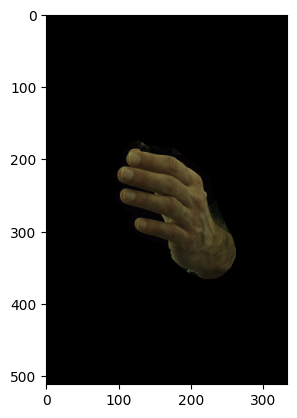

In [14]:
show_ids = [2]
show_dataset = dataset_extr_to_mano.NeumanDataset(data_path, show_ids)
show_loader = DataLoader(show_dataset, batch_size=1, shuffle=True, num_workers=5)

point_cloud_list = []
for batch in show_loader:

    camera_params, images, silhouettes, manos = batch

    batch_cameras = PerspectiveCameras(
        R=camera_params['R_pytorch3d'],
        T=camera_params['t_pytorch3d'],
        focal_length=camera_params['focal'],
        principal_point=camera_params['princpt'],
        in_ndc=False,
        image_size=camera_params['image_size'],
        device='cpu'
    )
    depths = batch_cameras.get_world_to_view_transform().transform_points(
        manos['verts']
    )[:, :, 2:]
    min_depth = depths.min() * 0.95
    max_depth = depths.max() * 1.05

    raysampler_train = NDCMultinomialRaysampler(
                image_height=int(camera_params['image_size'][0][1]),
                image_width=int(camera_params['image_size'][0][0]),
                n_pts_per_ray=32,
                min_depth=min_depth,
                max_depth=max_depth,
                stratified_sampling=False,
            )
    with torch.no_grad():
        ray_bundle = raysampler_train(batch_cameras.to('cuda'))
        rays_densities, rays_colors = model.neural_radiance_field.batched_forward(
            ray_bundle,
            vertices=manos['verts'].to('cuda'),
            Ts=manos['Ts'].to('cuda'),
            warp_rays=True,
        )

    print('fraction occupied > 0.1', np.mean(rays_densities.cpu().numpy() > 0.1))
    print('fraction occupied > 0.9', np.mean(rays_densities.cpu().numpy() > 0.9))

    rays_points_world = ray_bundle_to_ray_points(ray_bundle)

    # keep the points with opacity > 0.1
    points_reshaped = rays_points_world.reshape(-1, 3)
    rays_colors_reshaped = rays_colors.reshape(-1, 3)
    rays_densities_reshaped = rays_densities.reshape(-1, 1)

    threshold = 0.1

    points_reshaped = points_reshaped[rays_densities.reshape(-1) > threshold].cpu().numpy()
    rays_colors_reshaped = rays_colors_reshaped[rays_densities.reshape(-1) > threshold].cpu().numpy()
    rays_densities_reshaped = rays_densities_reshaped[rays_densities.reshape(-1) > threshold].cpu().numpy()

    # print('rays_densities_reshaped.shape', rays_densities_reshaped.shape, rays_densities_reshaped.dtype, rays_densities_reshaped.min(), rays_densities_reshaped.max())
    # print('rays_colors_reshaped.shape', rays_colors_reshaped.shape, rays_colors_reshaped.dtype, rays_colors_reshaped.min(), rays_colors_reshaped.max())
    rays_colors_rgba = np.concatenate((rays_colors_reshaped, rays_densities_reshaped), axis=1)

    # convert colors from [0, 1] to [0, 255]
    rays_colors_rgba = rays_colors_rgba * 255
    rays_colors_rgba = rays_colors_rgba.astype(np.uint8)

    point_cloud = trimesh.PointCloud(points_reshaped, colors=rays_colors_rgba)
    point_cloud_list.append(point_cloud)

    import matplotlib.pyplot as plt
    plt.imshow(images[0].cpu().numpy())

scene = trimesh.Scene()
for point_cloud in point_cloud_list:
    scene.add_geometry(point_cloud)

mano_mesh = manos['verts'][0].cpu().numpy()
# shift mano mesh by 0.2 in z direction
mano_mesh[:, 2] += 0.2

faces = model.hand_model.faces
mano_mesh = trimesh.Trimesh(vertices=mano_mesh, faces=faces)

# scene.add_geometry(mano_mesh)
# scene.add_geometry(trimesh.creation.axis(axis_length=0.15, axis_radius = 0.001, origin_size=0.001))

scene.show()